# Dimenstionality Reduction Project:

In [89]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


<font color = blue size =5><b>Load the swiss_roll dataset, use KernalPCA to reduce the the dataset to 2 dimensions, visualize the reuslts!</font>

Set n_components = 2, and try different kernels and different hyperparams! Remember, we want to "UNROLL" the swiss roll so we can linearly separate the data for easy classification.

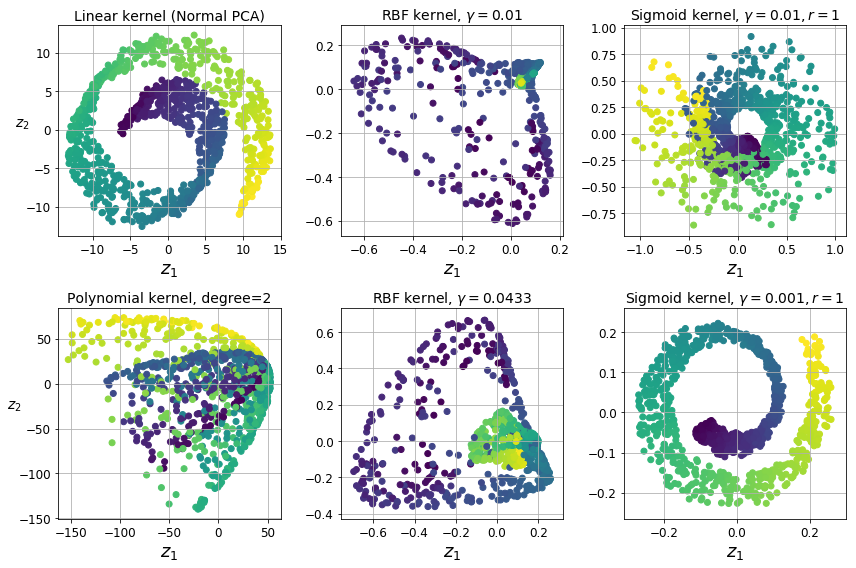

In [90]:
#LOAD DATA and visualize different KernelPCA methods
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import KernelPCA

#extract data and colors!
X, y = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42) #extract data and classes!

#initialize kernalPCA
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
poly_pca = KernelPCA(n_components = 2, kernel="poly", degree=2, fit_inverse_transform=True)
rbf_pca1 = KernelPCA(n_components = 2, kernel="rbf", gamma=0.1, fit_inverse_transform=True)
rbf_pca2 = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca1 = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.01, coef0=1, fit_inverse_transform=True)
sig_pca2 = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

plt.figure(figsize=(12, 8))
for subplot, pca, title in ((231, lin_pca, "Linear kernel (Normal PCA)"),
                            (234, poly_pca, "Polynomial kernel, degree=2"),
                            (232, rbf_pca1, "RBF kernel, $\gamma=0.01$"),
                            (235, rbf_pca2, "RBF kernel, $\gamma=0.0433$"),
                            (233, sig_pca1, "Sigmoid kernel, $\gamma=0.01, r=1$"),
                            (236, sig_pca2, "Sigmoid kernel, $\gamma=0.001, r=1$")):
    
    X_reduced = pca.fit_transform(X)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 231 or subplot == 234:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)
    plt.tight_layout()

plt.show()

<font color = blue size =5><b> It's difficult to tell from these visualizations which Kernel works best. Run GridSearchCV to test and see which Kernel performs the best for Machine Learning</font>

Create a pipeline that:
1. Perfoms PCA on the data to reduce its size and dimensions
2. Runs a logistic regression to predict the classes

Test out the rbf and sigmoid kernels, and test for gamma values from 0.001 to 0.05.
You can access the subparamaters of a function you are calling in a pipeline by using the DOUBLE UNDERSCORE! (ie "__")

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#set up pipeline and paramter grid 
pipeline_clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.001, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid", "poly"]
    }]

#convert y from continous to binary class
y_class = y > 6.9

#Run pipeline clf as your 'model' parameter in the Gridsearch
grid_search = GridSearchCV(pipeline_clf, param_grid, cv=3)
grid_search.fit(X, y_class)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([ 0.001  ,  0.00644,  0.01189,  0.01733,  0.02278,  0.02822,
        0.03367,  0.03911,  0.04456,  0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid', 'poly']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [92]:
print(grid_search.best_params_)

{'kpca__gamma': 0.044555555555555557, 'kpca__kernel': 'rbf'}


#### Looks like the rbf kernel with gamma value of 0.04 seems to work the best. This makes sense, as if we look at the visualization, the rbf kernel seems to more clearly separate the classes linearly. 

<font color = blue size =5><b> Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). </font>

Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier?

#### 1. Load MNIST data

In [93]:
# load MNIST data and split train/test sets
from six.moves import urllib
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')
X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/7)
print("train shape: ",X_train.shape)
print("test shape: ",X_test.shape)

train shape:  (60000, 784)
test shape:  (10000, 784)


#### 2. Train/Test normal RF model

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

rnd_clf = RandomForestClassifier()

#time training
t1 = time.time()
rnd_clf.fit(X_train,y_train)
t2 = time.time()
print('MODEL 1')
print('Model runtime: ', str(t2-t1) + ' seconds')

#test accuracy
preds = rnd_clf.predict(X_test)
print('FIRST Accuracy: ',accuracy_score(y_test,preds),'\n')

#show params
print('max depth',[estimator.tree_.max_depth for estimator in rnd_clf.estimators_])
print('min samples split',[estimator.min_samples_split for estimator in rnd_clf.estimators_])
print('min samples leaf',[estimator.min_samples_leaf for estimator in rnd_clf.estimators_])
print('max leaf nodes',[estimator.max_leaf_nodes for estimator in rnd_clf.estimators_])

MODEL 1
Model runtime:  7.349556922912598 seconds
FIRST Accuracy:  0.9457 

max depth [35, 41, 35, 35, 34, 30, 44, 35, 34, 35]
min samples split [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
min samples leaf [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
max leaf nodes [None, None, None, None, None, None, None, None, None, None]


#### 3. Train/Test REDUCED RF model

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test) #only use transform()... NOT fit_transform() 
rnd_clf = RandomForestClassifier(random_state=42)

#time training
t1 = time.time()
rnd_clf.fit(X_train_reduced,y_train)
t2 = time.time()
print('MODEL 2')
print('Model runtime: ', str(t2-t1) + ' seconds')

#test accuracy
preds = rnd_clf.predict(X_test_reduced)
print('Accuracy: ',accuracy_score(y_test,preds),'\n')

#show params
print('max depth',[estimator.tree_.max_depth for estimator in rnd_clf.estimators_])
print('min samples split',[estimator.min_samples_split for estimator in rnd_clf.estimators_])
print('min samples leaf',[estimator.min_samples_leaf for estimator in rnd_clf.estimators_])
print('max leaf nodes',[estimator.max_leaf_nodes for estimator in rnd_clf.estimators_])

MODEL 2
Model runtime:  14.01253604888916 seconds
Accuracy:  0.8888 

max depth [30, 34, 36, 50, 38, 39, 31, 43, 40, 40]
min samples split [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
min samples leaf [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
max leaf nodes [None, None, None, None, None, None, None, None, None, None]


Interesting! The number of dimensions was reduced to 154 features, however the accuracy of the dimensionally reduced model was also reduced by about 5%; this is expected, as we do lose some useful signal in the process of dimensionality reduction. This could probably be improved with some GridSearchCV hyperparamter tuning. **In addition, the model also appeared to take even longer to train than the non-reduced dataset! I'm not exactly sure why this is. **

Let's try the same analysis using a Softmax Regression as it takes much longer to train (here I'm using example from the text book for my own reference later)!

#### 4. Testing PCA with LogisticRegression (using softmax solver)

In [96]:
#test WITHOUT PCA
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)
print('Accuracy: ',accuracy_score(y_test,y_pred))

Training took 22.57s
Accuracy:  0.9174


In [97]:
#test WITH PCA
log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

y_pred = log_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)
print('Accuracy: ',accuracy_score(y_test,y_pred))

Training took 8.54s
Accuracy:  0.9132


 **Wooohoo only a slight drop in performance for a very significant (4x) speed boost!!!** Even though this model still isnt as strong as the RandomForest model, its clear that <font color =red> PCA can be super useful in certian contexts!</font>

<font color = blue size =5><b> Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. </font>

- You can use a scatterplot using 10 different colors to represent each image’s target class. 
- Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

#### Load the data. Use random subset of the data as training the full set takes too long

In [98]:
from sklearn.datasets import fetch_mldata
import numpy as np
mnist = fetch_mldata('MNIST original')

datasize = 5000
idx = np.random.permutation(60000)[:datasize] #get random index

X = mnist['data'][idx]
y = mnist['target'][idx]

#### Use t-SNE to reduce dimensionality down to 2D and plot dataset

In [99]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=42)
t0 = time.time()
X_reduced_tsne = tsne.fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))

t-SNE took 223.3s.


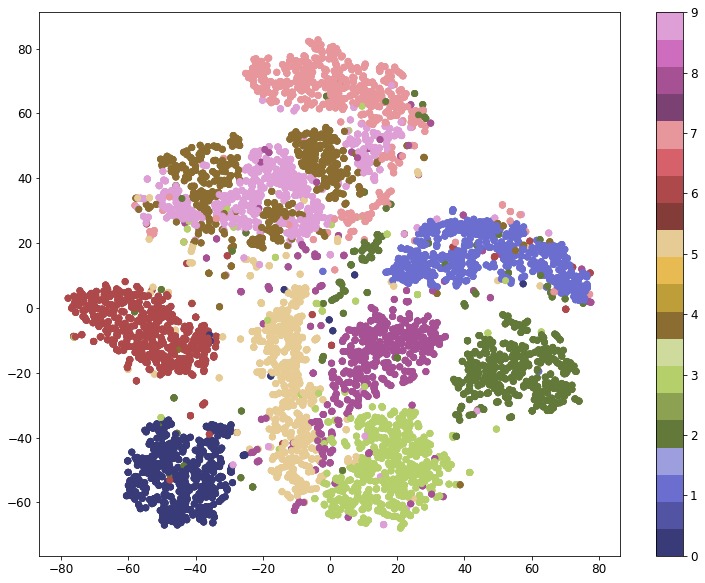

In [100]:
plt.figure(figsize=(13,10))
for digit in (2,3,5):
    plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y, cmap="tab20b") #set discrete color map
    plt.axis('on')
plt.colorbar()
plt.show()

#### Plot images overtop of the plot 

In [101]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.075, X_images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    #for digit in digits:
    #    plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=cmap(digit / 9))
    plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=y, cmap="tab20b" )
    plt.axis("on")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        # need the min function because you want to keep choosing the next closest neighbour (as neighbours var extends)
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        # if closest_distance is further than min distance, add to list of neighors you want to plot
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if X_images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = X_images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)
    plt.show()

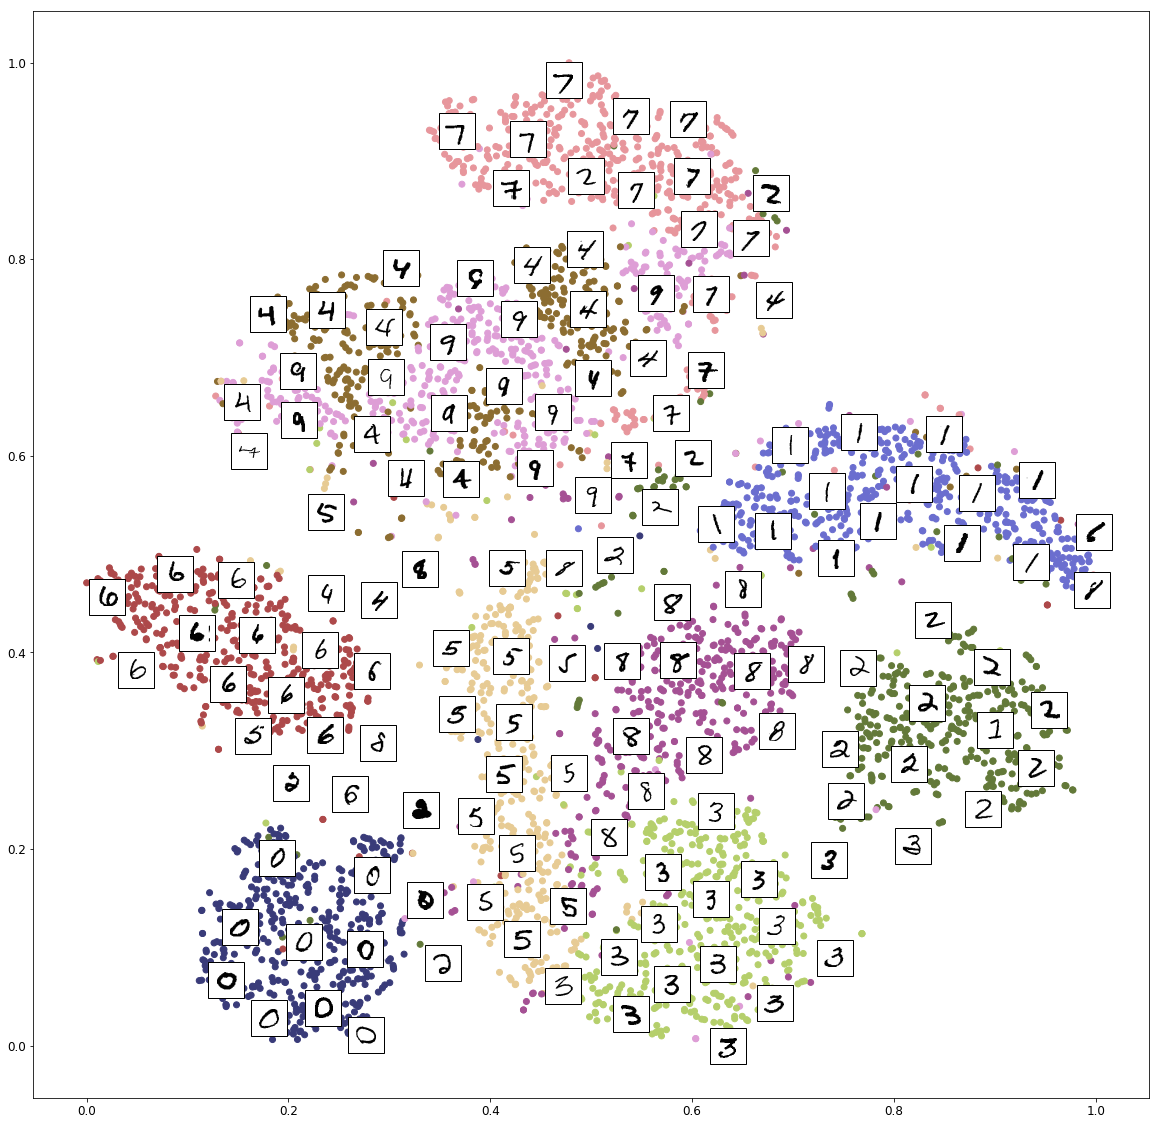

In [102]:
plot_digits(X_reduced_tsne, y, min_distance=0.05, X_images = X, figsize = (20,20))

#### Isolate digits 2, 3, and 5, as they appear to be ovrelapping a little

In [103]:
### CREATE BOOLEAN FILTER TO SELECT ONLY 2S, 3S, AND 5S ###
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

print(idx.shape)
print(y_subset.shape)

(5000,)
(1492,)


In [104]:
from sklearn.manifold import TSNE
tsne_subset = TSNE(n_components=2, random_state=42)
t0 = time.time()
X_subset_reduced = tsne_subset.fit_transform(X_subset)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))

t-SNE took 57.5s.


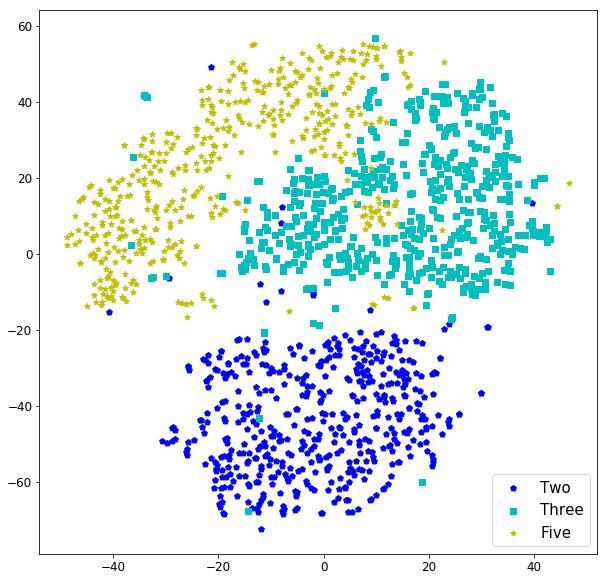

In [105]:
digits = [2,3,5]
labels = ['Two','Three','Five']
colors = ['b', 'c', 'y']
markers = ['p', 's', '*']

plt.figure(figsize=(10,10))
a = plt.scatter(X_subset_reduced[y_subset==digits[0], 0], X_subset_reduced[y_subset==digits[0], 1], marker=markers[0], color=colors[0])
b = plt.scatter(X_subset_reduced[y_subset==digits[1], 0], X_subset_reduced[y_subset==digits[1], 1], marker=markers[1], color=colors[1])
c = plt.scatter(X_subset_reduced[y_subset==digits[2], 0], X_subset_reduced[y_subset==digits[2], 1], marker=markers[2], color=colors[2])

plt.legend((a, b, c),
           (labels[0], labels[1], labels[2]),
           scatterpoints=1,
           loc='lower right',
           ncol=1,
           fontsize=15)

plt.show()

####  Comparing visuals using other dimensionality reduction models (reduce training set to 2k to reduce training time)

In [106]:
import time
######### use a smaller set to speed up the training #########
mnist = fetch_mldata('MNIST original')
datasize = 2000
idx = np.random.permutation(60000)[:datasize]
X = mnist['data'][idx]
y = mnist['target'][idx]

**t-Distributed Stochastic Neighbor Embedding (t-SNE)**: reduced dimensionality while trying to keep similar instances CLOSE and dissimilar instances FAR APART. <font color=red> It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g. to visualize MNIST images in 2d).</font>

In [107]:
# TSNE Model
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state=42)
t0 = time.time()
X_reduced_tsne = tsne.fit_transform(X)
t1 = time.time()
time_tsne = round(t1-t0,2)
print("Complete TSNE: ",time_tsne)

Complete TSNE:  83.04


**Multidimensional Scaling (MDS):** reduces dimensionality while trying to <font color=red> preserve the distances between the instances. </font>

In [108]:
# MDS Model
from sklearn.manifold import MDS
mds = MDS(n_components=2, random_state=42)
t0 = time.time()
X_reduced_mds = mds.fit_transform(X)
t1 = time.time()
time_mds = round(t1-t0,2)
print("Complete MDS: ",time_mds)

Complete MDS:  219.63


**Isomap:** creates a graph by connecting each instance to its nearest neighbors <font color=red> then reduces dimensionality while trying to preserve the geodesic distances between instances. </font>

In [109]:
# Isomap model
from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
t0 = time.time()
X_reduced_isomap = isomap.fit_transform(X)
t1 = time.time()
time_iso = round(t1-t0,2)
print("Complete ISO: ",time_iso)

Complete ISO:  9.51


**Linear Discrimination Analysis (LDA):** is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. <font color=red> The benefit is that the projection will keep classes as far apart as possible, **so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.** </font>

In [110]:
# LinearDiscriminant model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
t0 = time.time()
X_reduced_lda = lda.fit_transform(X,y)
t1 = time.time()
time_lda = round(t1-t0,2)
print("Complete LDA: ",time_lda)

Complete LDA:  0.7


C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


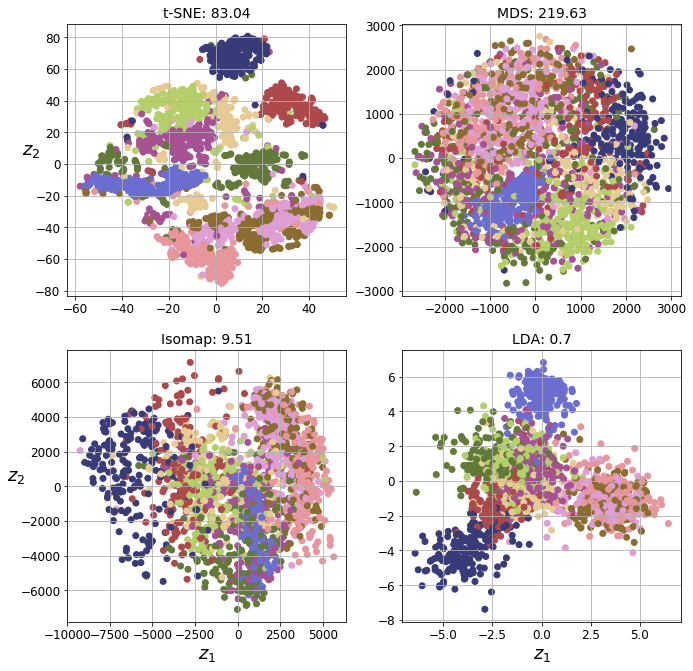

In [111]:
######### plot all models #########
titles = ["t-SNE", "MDS", "Isomap", "LDA"]
plots = [221, 222, 223, 224]
models = [X_reduced_tsne, X_reduced_mds, X_reduced_isomap, X_reduced_lda]
times = [time_tsne,time_mds,time_iso,time_lda]
plt.figure(figsize=(11,11))
for subplot, title, X_reduced, time in zip(plots,titles, models,times):
    plt.subplot(subplot)
    plt.title(title+": "+str(time), fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="tab20b")
    if (subplot == 221) | (subplot == 223):
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    if (subplot == 223) | (subplot == 224):  
        plt.xlabel("$z_1$", fontsize=18)

    plt.grid(True)

plt.show()

TSNE is definitely the best. However it also takes a really long time to train... <font color=red>Let try speeding it up with PCA (Linear) first, **because PCA is really fast!** Let's also try it on a 10k row dataset just as we did with the first TSNE run.</font>

<font color=red size=4><br>**It often makes sense to chain two different dimensionality reduction algorithms: common example is using PCA to quickly get rid of a large number of useless dimensions, then applying another much slower dimensionality reduction algorithm, such as LLE or t-SNE.**</font> 

**This two-step approach will likely yield the same performance as using LLE only, but in a fraction of the time.**

Complete PCA_TSNE @ 436.57 seconds


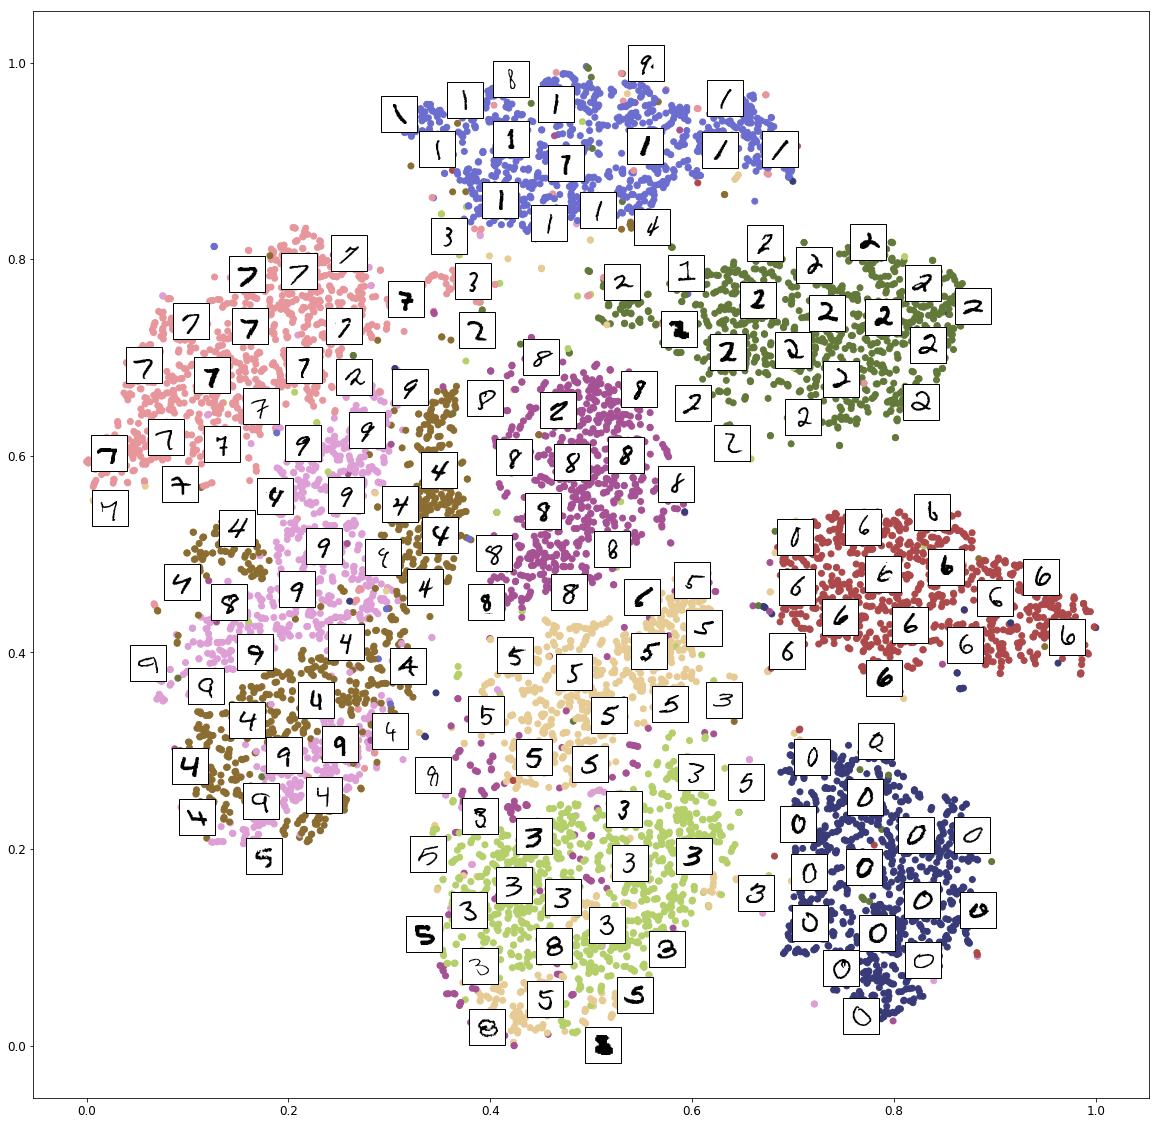

In [112]:
import time
mnist = fetch_mldata('MNIST original')
datasize = 10000
idx = np.random.permutation(60000)[:datasize]
X = mnist['data'][idx]
y = mnist['target'][idx]

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
time_pca_tsne = round(t1-t0,2)
print("Complete PCA_TSNE @ " +str(time_pca_tsne) + " seconds")

plot_digits(X_pca_tsne_reduced, y, min_distance=0.05, X_images = X, figsize=(20,20))                   

<font color=blue size=5><b> Great! The results look comparable (the clusters seem to be similar) and the training time was reduced by around 150 seconds. Not bad!